# Multivariate time series forecasting using LSTM using cycle-feature.

In [1]:
%reset -f
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 10,10
from sklearn.preprocessing import StandardScaler 
from functionsAll import lstmMultiSplit, originalToRecurring, recurringToOrignal
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras

functionsAll.py loaded successfully


## Data cleaning.

In [6]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [7]:
df

,wert,day,month,dayofyear,year,weekday,week,hour,temp,dwpt,rhum,prcp
0,36,2,1,2,2020,3,1,0,1.0,-0.6,89.0,0.0
1,31,2,1,2,2020,3,1,7,0.1,-1.2,91.0,0.0
2,32,2,1,2,2020,3,1,6,-0.3,-1.3,93.0,0.0
3,27,2,1,2,2020,3,1,5,-0.5,-1.2,95.0,0.0
4,38,2,1,2,2020,3,1,4,-0.4,-0.8,97.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23731,27,30,9,273,2022,4,39,20,12.9,7.3,69.0,0.0
23732,30,30,9,273,2022,4,39,21,13.1,7.3,68.0,0.0
23733,37,30,9,273,2022,4,39,22,12.7,7.6,71.0,0.0
23734,27,30,9,273,2022,4,39,23,12.6,7.5,71.0,0.0


In [8]:
cyDf = df[['day','month','dayofyear','weekday', 'week', 'hour']] # [32,13,367,7,54,52]
scDf = df[['wert','year' , 'temp', 'dwpt', 'rhum', 'prcp']]

## Data normalizing

In [10]:
day = cyDf['day']
day.to_numpy()
day = originalToRecurring(ogUnits=day,period=32)
cyDf['day_sin'] = day[:,0]
cyDf['day_cos'] = day[:,1]

month = cyDf['month']
month.to_numpy()
month = originalToRecurring(ogUnits=month,period=13)
cyDf['month_sin'] = month[:,0]
cyDf['month_cos'] = month[:,1]

dayofyear = cyDf['dayofyear']
dayofyear.to_numpy()
dayofyear = originalToRecurring(ogUnits=dayofyear,period=367)
cyDf['dayofyear_sin'] = dayofyear[:,0]
cyDf['dayofyear_cos'] = dayofyear[:,1]

weekday = cyDf['weekday']
weekday.to_numpy()
weekday = originalToRecurring(ogUnits=weekday,period=7)
cyDf['weekday_sin'] = weekday[:,0]
cyDf['weekday_cos'] = weekday[:,1]

week = cyDf['week']
week.to_numpy()
week = originalToRecurring(ogUnits=week,period=54)
cyDf['week_sin'] = week[:,0]
cyDf['week_cos'] = week[:,1]

hour = cyDf['hour']
hour.to_numpy()
hour = originalToRecurring(ogUnits=hour,period=25)
cyDf['hour_sin'] = hour[:,0]
cyDf['hour_cos'] = hour[:,1]

In [11]:
cyDf.drop(['day', 'month', 'dayofyear', 'weekday', 'week','hour'], axis=1, inplace=True)

In [12]:
cyDf

,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,week_sin,week_cos,hour_sin,hour_cos
0,0.382683,0.923880,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.000000,1.000000
1,0.382683,0.923880,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.982287,-0.187381
2,0.382683,0.923880,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.998027,0.062791
3,0.382683,0.923880,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.951057,0.309017
4,0.382683,0.923880,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.844328,0.535827
...,...,...,...,...,...,...,...,...,...,...,...,...
23731,-0.382683,0.923880,-0.935016,-0.354605,-0.999258,-0.038511,-0.433884,-0.900969,-0.984808,-0.173648,-0.951057,0.309017
23732,-0.382683,0.923880,-0.935016,-0.354605,-0.999258,-0.038511,-0.433884,-0.900969,-0.984808,-0.173648,-0.844328,0.535827
23733,-0.382683,0.923880,-0.935016,-0.354605,-0.999258,-0.038511,-0.433884,-0.900969,-0.984808,-0.173648,-0.684547,0.728969
23734,-0.382683,0.923880,-0.935016,-0.354605,-0.999258,-0.038511,-0.433884,-0.900969,-0.984808,-0.173648,-0.481754,0.876307


In [13]:
scaler = StandardScaler()
scaler = scaler.fit(scDf)
scaledDf = scaler.transform(scDf)

### Combine in one dataframe. [cycle + normalize]

In [14]:
cyDf['wert'] = scaledDf[:,0]
cyDf['year'] = scaledDf[:,1]
cyDf['temp'] = scaledDf[:,2]
cyDf['dwpt'] = scaledDf[:,3]
cyDf['rhum'] = scaledDf[:,4]
cyDf['prcp'] = scaledDf[:,5]
mainDf = cyDf[['wert','day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin',
        'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
        'hour_sin', 'hour_cos', 'temp', 'dwpt', 'rhum', 'prcp']]

In [15]:
mainDf.head(5)

,wert,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,week_sin,week_cos,hour_sin,hour_cos,temp,dwpt,rhum,prcp
0,1.680347,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.000000,1.000000,-1.566281,-1.385630,0.792786,-0.154285
1,1.188967,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.982287,-0.187381,-1.691633,-1.490882,0.903869,-0.154285
2,1.287243,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.998027,0.062791,-1.747346,-1.508424,1.014952,-0.154285
3,0.795863,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.951057,0.309017,-1.775202,-1.490882,1.126034,-0.154285
4,1.876899,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.844328,0.535827,-1.761274,-1.420714,1.237117,-0.154285


## Data windowing and splitting

In [16]:
mianNp = mainDf.to_numpy()

In [17]:
mainDf.shape

(23736, 17)

In [18]:
train = mianNp[:23000]
test = mianNp[23000:] 

In [19]:
trainX, trainY = lstmMultiSplit(df=train, n_past=5, n_future=1)
testX, testY = lstmMultiSplit(df=test, n_past=5, n_future=1)

In [20]:
trainX.shape

(22995, 5, 17)

In [21]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model = keras.models.load_model('../models/ml04-1/ml04-1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            74752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 136,609
Trainable params: 136,609
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(trainX, trainY, epochs=30, batch_size=12, validation_split=0.1, verbose=1)

Epoch 1/30
1725/1725 [==============================] - 16s 8ms/step - loss: 0.5580 - val_loss: 0.2180
Epoch 2/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4866 - val_loss: 0.1981
Epoch 3/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4803 - val_loss: 0.1961
Epoch 4/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4652 - val_loss: 0.1943
Epoch 5/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4585 - val_loss: 0.1935
Epoch 6/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4510 - val_loss: 0.1947
Epoch 7/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4538 - val_loss: 0.2035
Epoch 8/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4396 - val_loss: 0.2013
Epoch 9/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4323 - val_loss: 0.1956
Epoch 10/30
1725/1725 [==============================] - 14s 8ms/step - l

In [89]:
print(f"Train accuracy using LSTM and cycle-feature: {model.evaluate(trainX, trainY,batch_size=64)*100:.2f}%")

print(f"Test accuracy using LSTM and cycle-feature:: {model.evaluate(testX, testY,batch_size=64)*100:.2f}%")

 14/360 [>.............................] - ETA: 1s - loss: 0.2614

360/360 [==============================] - 1s 3ms/step - loss: 0.2122
Train accuracy using LSTM and cycle-feature: 21.22%
12/12 [==============================] - 0s 3ms/step - loss: 0.2559
Test accuracy using LSTM and cycle-feature:: 25.59%


- Train accuracy using LSTM with-out cycle-feature: 24.37%
- Test accuracy using LSTM with-out cycle-feature: 31.69%

- Train accuracy using LSTM with cycle-feature: 21.22%
- Test accuracy using LSTM with cycle-feature: 25.59%

In [22]:
prediction = model.predict(testX)

In [23]:
prediction = np.repeat(prediction, 6, axis=-1)
realPrediction = scaler.inverse_transform(prediction)
realPrediction = realPrediction[:,0]

In [24]:
yt = df.query('index >= 23005')
yt = yt['wert']
yt.reset_index(drop=True, inplace=True)

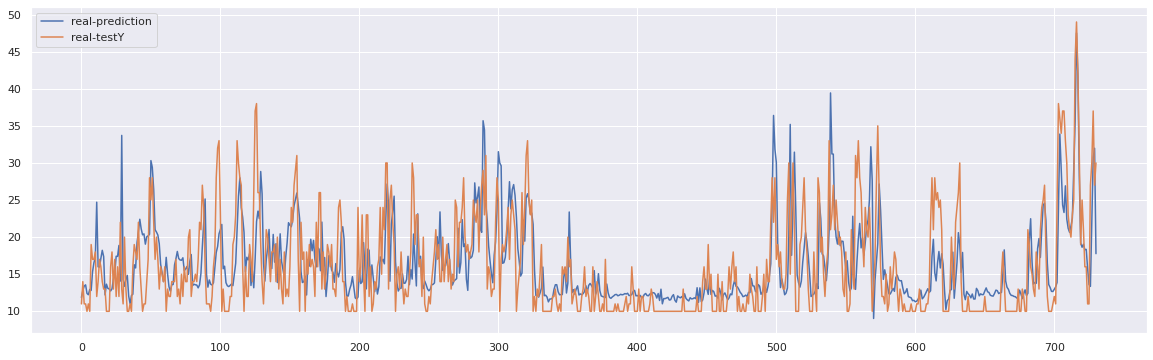

In [25]:
rcParams['figure.figsize'] = 20,6
plt.plot(realPrediction, label='real-prediction')
plt.plot(yt, label='real-testY')
plt.legend() 
plt.show()

In [91]:
model.save('../models/ml04-1/ml04-1.h5')

In [28]:
pdf.to_csv('../models/ml04-1/predictions.csv', index=False)

## Evaluate the model

In [29]:
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as RMSE, mean_absolute_percentage_error as MAPE, r2_score as R2
yPred = realPrediction 
yTrue = yt

In [30]:
print(f"The MAE (Mean Absolute Error) of model ml04-1 is : {MAE(yTrue, yPred)}") 
print(f"The RMSE (Root Mean Square Error) of model ml04-1 is : {RMSE(yTrue, yPred)}")
print(f"The MAPE (Mean Absolute Percentage Error) of model ml04-1 is : {MAPE(yTrue, yPred)}")
print(f"The R2 (R-Square) of model ml04-1 is : {R2(yTrue, yPred)}")

The MAE (Mean Absolute Error) of model ml04-1 is : 3.787804607490508
The RMSE (Root Mean Square Error) of model ml04-1 is : 26.492051649690026
The MAPE (Mean Absolute Percentage Error) of model ml04-1 is : 0.24308146281971896
The R2 (R-Square) of model ml04-1 is : 0.3778346774200916
